# GLM Model : Pure Premium Model 

#### Use SKlean API : Poisson and Gamma Regression

Multi-variate Model 02 : Frequency-Severity Method

1.Model with cgroup, tgroup

2.Model with Annual Milage as a Predictor

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

## Part 1 : Training Data

### Read Data

In [3]:
data = pd.read_csv('data_purepremium_train.csv')

In [4]:
print( data.shape )
# data.head(3)

(99947, 8)


###  Process Data

Filter Total Loss 

In [5]:
print( 'ClaimNumber before processing :', np.sum( data.ClaimNum>0) )
print(data.groupby(by=['ClaimNum']).size().values )

_TotLoss_ = data.apply( lambda x : 0.0 if x.TotLoss<50.0 else x.TotLoss, axis=1 )
data['TotLoss']  = _TotLoss_ 

_ClaimNum_ = data.apply( lambda x : 0.0 if x.TotLoss==0.0 else x.ClaimNum, axis=1 )
data['ClaimNum'] = _ClaimNum_

print( 'ClaimNumber after processing  :', np.sum( data.ClaimNum>0) )
print( data.groupby(by=['ClaimNum']).size().values )

ClaimNumber before processing : 4302
[95645  4117   178     7]
ClaimNumber after processing  : 4125
[95822  3942   176     7]


Check Agrregate Risks  

In [6]:
print( 'Claim Frequency :', round(data.ClaimNum.sum()/data.EarnExpo.sum(),4) ) 
print( 'Claim Severity  :', round(data.TotLoss.sum()/data.ClaimNum.sum(),2) ) 
print( 'Pure Premium    :', round( data.TotLoss.sum()/data.EarnExpo.sum(),2) ) 

Claim Frequency : 0.0496
Claim Severity  : 2954.24
Pure Premium    : 146.54


#### Select  Columns

In [7]:
df = data[['ann_miles','cgroup','tgroup','rateclass','TotLoss','ClaimNum','EarnExpo']]

####  Apply One-hot Encoding

In [8]:
# pd.CategoricalIndex(df.cgroup)

In [9]:
# pd.CategoricalIndex(df.tgroup)

In [10]:
# pd.CategoricalIndex(df.rateclass)

In [14]:
def relevel(data, feature_name, base_level):
    
    if data[feature_name].dtype=='int':
        feature = data[feature_name].astype(str)
    else:
        feature = data[feature_name]
    
    categories = pd.CategoricalIndex(feature).categories
    categories = categories.to_numpy(dtype='str')
    
    base_level_index = np.where(categories==str(base_level))[0][0]
    
    _categories = np.delete( categories, base_level_index )
    categories = [str(base_level)] + list(_categories)

    releveled_feature = pd.CategoricalIndex(
        feature, 
        categories=categories,
        ordered=True)
    
    releveled_feature = releveled_feature.to_frame()
    
    return releveled_feature.reset_index(drop=True)

In [15]:
_x1 = relevel(df, 'cgroup', 'A')
_x2 = relevel(df, 'tgroup', 6)
_x3 = relevel(df, 'rateclass', 1)

#### Numerical X

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

tmp = df[['ann_miles']]

scale = MinMaxScaler()
tmp = scale.fit_transform(tmp.values)

XN = pd.DataFrame(tmp, columns=['ann_miles'])   # X Numerical

#### Categorical  X

In [17]:
XC = pd.concat([_x1,_x2], axis=1)               # X categorical 

### Model 1 : Claim Frequency

Get X,y

In [18]:
_XC_ = pd.get_dummies( XC, drop_first=True )      

In [19]:
X = pd.concat([XN,_XC_], axis=1)

In [20]:
y = df.ClaimNum.to_numpy()/df.EarnExpo.to_numpy()

In [21]:
print('y min  :', y.min())
print('y max  :', y.max())
print('')
print('y mean :', np.mean(y) )
print('y stdev:', np.std(y) )

y min  : 0.0
y max  : 12.000000048

y mean : 0.050288846763578525
y stdev: 0.3064869069994762


Plot y

In [22]:
# fig, ax = plt.subplots(1,1, figsize=(16,5))
# ax.hist( y, bins=21  )
# plt.show()

Get weights

In [23]:
weights = df.EarnExpo.to_numpy()

Build model

In [24]:
from sklearn import linear_model
model_frequency = linear_model.PoissonRegressor(alpha=0.0001, fit_intercept=True)

model_frequency.fit(X, y, sample_weight=weights)

PoissonRegressor(alpha=0.0001)

In [25]:
model_frequency.score(X, y)

0.025469767657984588

Claim Frequency Prediction

In [26]:
y_pred_f = model_frequency.predict(X)
y_pred_f[0:5]

array([0.05761888, 0.04195795, 0.04087482, 0.04076834, 0.04415251])

Summary Statistics of Claim Frequency Prediction

In [27]:
np.quantile( y_pred_f, q=(0.0,0.25,0.50,0.75,1.0) )

array([0.02737787, 0.03661606, 0.04471902, 0.05590375, 0.46117223])

Claim Count Predic1tion

In [28]:
pred_count = weights * y_pred_f
pred_count[0:5]

array([0.05761888, 0.02797197, 0.04087482, 0.04076834, 0.04415251])

In [29]:
np.quantile( pred_count, q=(0.0,0.25,0.50,0.75,1.0) )

array([0.00229566, 0.03229864, 0.04011664, 0.05166957, 0.45823973])

In [30]:
print( 'actual claim count    :', df.ClaimNum.sum() )
print( 'predicted claim count :', round(sum(pred_count),2) )

actual claim count    : 4315.0
predicted claim count : 4315.37


Model Coefficients

In [31]:
# print( model_frequency.intercept_ )
# print( model_frequency.coef_[0:1] )
# print( model_frequency.coef_[1:] )

In [32]:
# print(model_frequency.feature_names_in_)
# print( len(model_frequency.feature_names_in_) )

Plot Model Coefficients

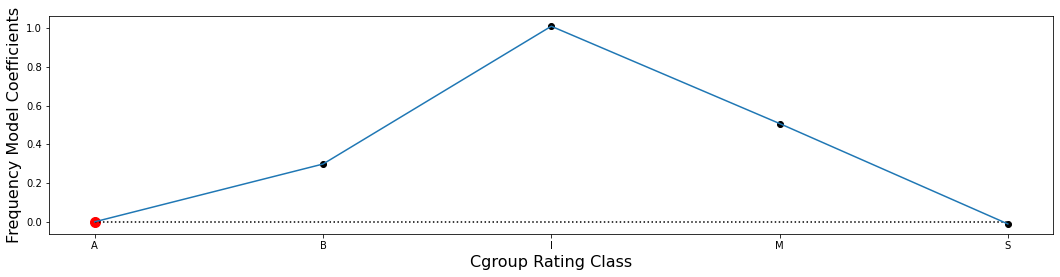

In [33]:
fig = plt.figure( figsize=(18,4) )

_coef = [0.0] + list(model_frequency.coef_[1:5])  


dx = np.sort(df.cgroup.unique())
dy =  np.zeros( len(dx) )
plt.plot(dx, dy, color='black', linestyle='dotted')

plt.scatter( np.sort(df.cgroup.unique()), _coef, color='black')
plt.scatter( np.sort(df.cgroup.unique())[0], _coef[0], s=100, color='red')
plt.plot(dx, _coef)


plt.xticks(dx)
# plt.ylim(-0.2, 1.0)
plt.xlabel('Cgroup Rating Class', fontdict={'size':16})
plt.ylabel('Frequency Model Coefficients', fontdict={'size':16})


plt.show()

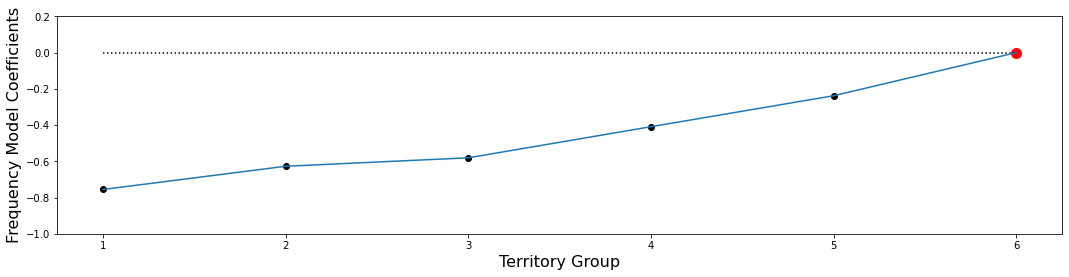

In [34]:
fig = plt.figure( figsize=(18,4) )

_coef = list(model_frequency.coef_[5:10]) + [0.0]


dx = np.sort(df.tgroup.unique())
dy =  np.zeros( len(dx) )
plt.plot(dx, dy, color='black', linestyle='dotted')

plt.scatter( np.sort(df.tgroup.unique()), _coef, color='black')
plt.scatter( np.sort(df.tgroup.unique())[5], _coef[5], s=100, color='red')
plt.plot(dx, _coef)


plt.xticks(dx)
plt.ylim(-1.0, 0.2)
plt.xlabel('Territory Group', fontdict={'size':16})
plt.ylabel('Frequency Model Coefficients', fontdict={'size':16})


plt.show()

Estimate Claim Frequency 

In [36]:
key = np.array(
    ['intercept', 
     'ann_miles',
     'cgroup_A','cgroup_B','cgroup_I','cgroup_M','cgroup_S',
     'tgroup_6','tgroup_1','tgroup_2','tgroup_3','tgroup_4','tgroup_5']
)

val = [model_frequency.intercept_] + list(model_frequency.coef_[0:1]) + [0.0] + list(model_frequency.coef_)[1:5] 
val = val + [0.0] + list(model_frequency.coef_)[5:] 
val = np.array([round(x,8) for x in val])

rel = np.array([ round(np.exp(x),8) for x in val]) 

In [37]:
_xn = XN
_xc = pd.get_dummies( XC, drop_first=False )
_xx = pd.concat([_xn, _xc], axis=1)

_bf = pd.DataFrame( np.column_stack((key,val,rel)), columns=['Feature','Estimate','Relativity'])

In [38]:
_bf

,Feature,Estimate,Relativity
0,intercept,-2.83189183,0.05890132
1,ann_miles,1.45303077,4.27605463
2,cgroup_A,0.0,1.0
3,cgroup_B,0.29813267,1.34734053
4,cgroup_I,1.00945298,2.74409953
5,cgroup_M,0.50729838,1.66079828
6,cgroup_S,-0.0109676,0.98909232
7,tgroup_6,0.0,1.0
8,tgroup_1,-0.7552919,0.46987344
9,tgroup_2,-0.62720565,0.53408213


In [39]:
def calcFrequency(data, coef, exposure):
    
    D = data.values
    
    if coef['Estimate'].dtype=='object':
        b = coef['Estimate'].astype('float64').to_numpy()
    
    b0 = b[0]
    b1 = b[1:]
    
    f = []
    for i in range(D.shape[0]):
        m = 1
        for j in range(len(b1)): 
            m *= np.exp(D[i,j] * b1[j])
            
        f.append( m*np.exp(b0) )
    
    return np.array( exposure*f )

Claim Frequency

In [40]:
_ee = np.exp( np.zeros( len(df.EarnExpo.values)) )

calc_pred_f = calcFrequency(_xx, _bf, _ee)

q = np.quantile( calc_pred_f, q=(0.0,0.25,0.50,0.75,1.0) )
[round(x,6) for x in q]

[0.027378, 0.036616, 0.044719, 0.055904, 0.461172]

Claim Count

In [41]:
_e = np.exp( np.log(df.EarnExpo.values) )

calc_count = calcFrequency(_xx,_bf,_ee)

q = np.quantile( calc_count, q=(0.0,0.25,0.50,0.75,1.0) )
[round(x,6) for x in q]

[0.027378, 0.036616, 0.044719, 0.055904, 0.461172]

Plot Estimated Frequency 

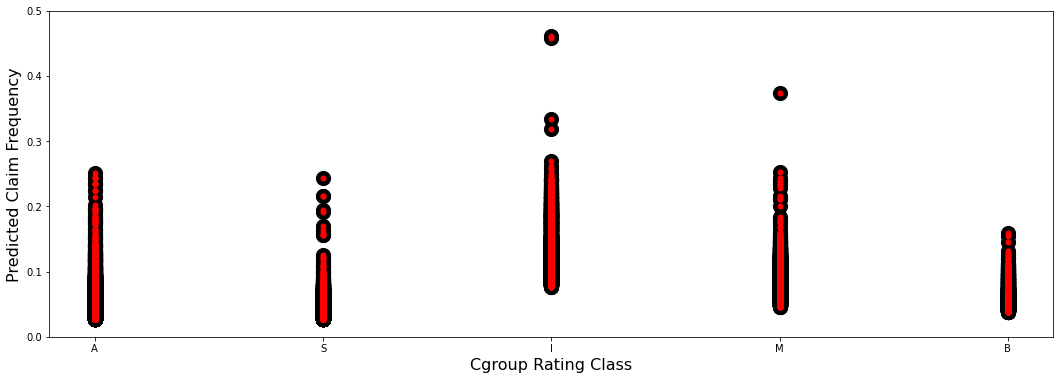

In [42]:
fig = plt.figure( figsize=(18,6) )


# Model Prediction
fx = df.cgroup.to_numpy()
fy = y_pred_f 
plt.scatter( fx, fy, s=200, color='black' )


def changeLabels(x):
    if x=='A':
        x=0
    elif x=='B':
        x=4
    elif x=='I':
        x=2
    elif x=='M':
        x=3
    else:
        x=1 
    return x

# tmp = pd.DataFrame({'x':fx, 'y':fy})
# tmp['labels'] = tmp.apply( lambda r : changeLabels(r.x), axis=1)
# tmp = tmp.sort_values(by=['labels']).reset_index(drop=False)
# plt.plot(tmp.labels, fy, color='tab:orange', linestyle='dotted', linewidth=6)
plt.ylim(0,0.50)



# Estimate from Coefficients
fx = df.cgroup.to_numpy()
fy = calc_pred_f 
plt.scatter( fx, fy, s=25, color='red' )

# tmp['labels'] = tmp.apply( lambda r : changeLabels(r.x), axis=1)
# tmp = tmp.sort_values(by=['labels']).reset_index(drop=False)
# plt.plot(tmp.labels, fy, color='tab:blue', linestyle='dotted', linewidth=6)
plt.ylim(0,0.50)


# plt.xticks( np.sort(np.unique(fx)) )
plt.xlabel('Cgroup Rating Class', fontdict={'size':16})
plt.ylabel('Predicted Claim Frequency', fontdict={'size':16})


plt.show()

### Model 2 : Claim Severity

Get X,y

In [43]:
df1 = df[ df.TotLoss > 0 ]

In [44]:
pos_loss_ind = df1.index.to_list()

In [45]:
_XN_ = XN.iloc[pos_loss_ind, :]
_XC_ = XC.iloc[pos_loss_ind, :]

In [46]:
XCPL = pd.get_dummies(_XC_, drop_first=True)    # XC Positive Loss

In [47]:
X = pd.concat([_XN_,XCPL], axis=1)

In [48]:
y = df1.TotLoss.to_numpy()/df1.ClaimNum.to_numpy()

In [49]:
print('y min  :', y.min())
print('y max  :', y.max())
print('')
print('y mean :', np.mean(y) )
print('y stdev:', np.std(y) )

y min  : 50.0
y max  : 43000.0

y mean : 2942.9714747474745
y stdev: 4534.75573108117


Plot y

In [50]:
# fig, ax = plt.subplots(1,1, figsize=(16,5))
# ax.hist( y, bins=101  )
# plt.show()

Get weights

In [51]:
weights = df1.ClaimNum.to_numpy()

Build model

In [52]:
from sklearn import linear_model

model_severity = linear_model.GammaRegressor(alpha=0.0, fit_intercept=True)

model_severity.fit(X, y, sample_weight=weights)

GammaRegressor(alpha=0.0)

In [53]:
model_severity.score(X, y)

0.005623198319896661

Average Loss Prediction

In [54]:
y_pred_s = model_severity.predict(X)
y_pred_s[0:5]

array([2927.85761628, 2986.57601558, 3032.30214119, 2532.91408486,
       2962.40395717])

Summary Statistics of Average Loss Prediction

In [55]:
np.quantile( y_pred_s, q=(0.0,0.25,0.50,0.75,1.0) )

array([2351.66243875, 2862.29603105, 2958.31568677, 3016.04541528,
       3816.03143244])

Total Loss Prediction

In [56]:
pred_loss = weights * y_pred_s
pred_loss[0:5]

array([2927.85761628, 2986.57601558, 3032.30214119, 2532.91408486,
       2962.40395717])

In [57]:
np.quantile( pred_loss, q=(0.0,0.25,0.50,0.75,1.0) )

array([ 2351.66243875,  2866.76252363,  2962.69758729,  3021.95051698,
       11006.72115754])

In [58]:
print( 'actual claim amount    :', df.TotLoss.sum() )
print( 'predicted claim amount :', round(sum(pred_loss),2) )

actual claim amount    : 12747526.0
predicted claim amount : 12748846.83


In [59]:
# print( model_severity.intercept_ )
# print( model_severity.coef_[0:1] )
# print( model_severity.coef_[1:] )

In [60]:
# print(model_severity.feature_names_in_)

Plot Model Coefficients

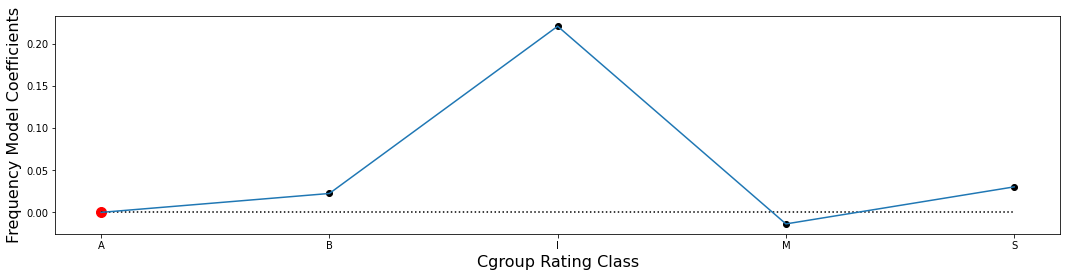

In [61]:
fig = plt.figure( figsize=(18,4) )

_coef = [0.0] + list(model_severity.coef_[1:5])  


dx = np.sort(df.cgroup.unique())
dy =  np.zeros( len(dx) )
plt.plot(dx, dy, color='black', linestyle='dotted')

plt.scatter( np.sort(df.cgroup.unique()), _coef, color='black')
plt.scatter( np.sort(df.cgroup.unique())[0], _coef[0], s=100, color='red')
plt.plot(dx, _coef)


plt.xticks(dx)
plt.xlabel('Cgroup Rating Class', fontdict={'size':16})
plt.ylabel('Frequency Model Coefficients', fontdict={'size':16})


plt.show()

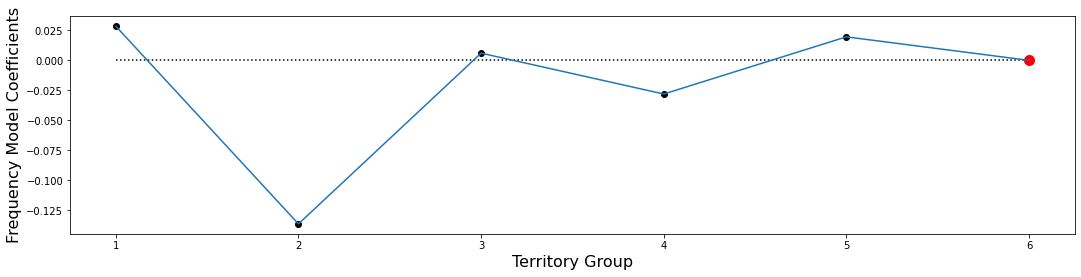

In [62]:
fig = plt.figure( figsize=(18,4) )

_coef = list(model_severity.coef_[5:10]) + [0.0]


dx = np.sort(df.tgroup.unique())
dy =  np.zeros( len(dx) )
plt.plot(dx, dy, color='black', linestyle='dotted')

plt.scatter( np.sort(df.tgroup.unique()), _coef, color='black')
plt.scatter( np.sort(df.tgroup.unique())[5], _coef[5], s=100, color='red')
plt.plot(dx, _coef)


plt.xticks(dx)
plt.xlabel('Territory Group', fontdict={'size':16})
plt.ylabel('Frequency Model Coefficients', fontdict={'size':16})


plt.show()

Estimate Claim Severity

In [63]:
key = np.array(
    ['intercept', 
     'ann_miles',
     'cgroup_A','cgroup_B','cgroup_I','cgroup_M','cgroup_S',
     'tgroup_6','tgroup_1','tgroup_2','tgroup_3','tgroup_4','tgroup_5']
)

val = [model_severity.intercept_] + list(model_severity.coef_[0:1]) + [0.0] + list(model_severity.coef_)[1:5] 
val = val + [0.0] + list(model_severity.coef_)[5:] 
val = np.array([round(x,8) for x in val])

rel = np.array([ round(np.exp(x),8) for x in val]) 

In [64]:
_xn = _XN_
_xc = pd.get_dummies( _XC_, drop_first=False )
_xx = pd.concat([_xn, _xc], axis=1)

_bs = pd.DataFrame( np.column_stack((key,val,rel)), columns=['Feature','Estimate','Relativity'])

In [65]:
_bs

,Feature,Estimate,Relativity
0,intercept,7.99923723,2978.68506869
1,ann_miles,-0.10497005,0.90035149
2,cgroup_A,0.0,1.0
3,cgroup_B,0.02248188,1.0227365
4,cgroup_I,0.22134636,1.24775553
5,cgroup_M,-0.01371668,0.98637696
6,cgroup_S,0.03035065,1.03081593
7,tgroup_6,0.0,1.0
8,tgroup_1,0.02840085,1.028808
9,tgroup_2,-0.13619976,0.87266829


In [66]:
def calcSeverity(data, coef, claimnumber):
    
    D = data.values
    
    if coef['Estimate'].dtype=='object':
        b = coef['Estimate'].astype('float64').to_numpy()
    
    b0 = b[0]
    b1 = b[1:]
    
    s = []
    for i in range(D.shape[0]):
        
        m = 1
        for j in range(len(b1)): 
            m *= np.exp(D[i,j] * b1[j])
            
        s.append( m*np.exp(b0) )
        
    return np.array(  claimnumber*s )

Average Severity

In [67]:
_cn = np.exp( np.zeros(len(df1.ClaimNum.values)) )

calc_pred_s = calcSeverity(_xx,_bs,_cn)

q = np.quantile( calc_pred_s, q=(0.0,0.25,0.50,0.75,1.0) )
[round(x,6) for x in q]

[2351.662443, 2862.296037, 2958.315692, 3016.045427, 3816.031443]

Total Loss

In [68]:
_cn = np.exp( np.log(df1.ClaimNum.values) )

calc_loss = calcSeverity(_xx,_bs,_cn)

q = np.quantile( calc_loss, q=(0.0,0.25,0.50,0.75,1.0) )
[round(x,6) for x in q]

[2351.662443, 2866.76252, 2962.697606, 3021.950529, 11006.721248]

Plot Estimated Severity

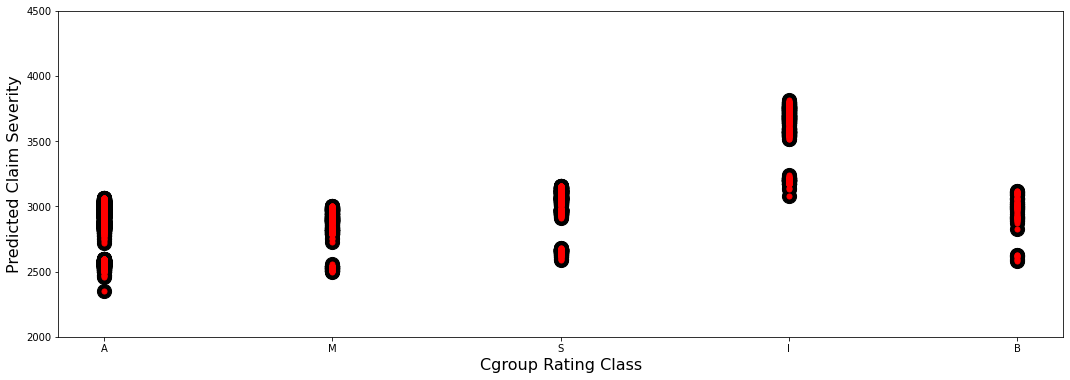

In [69]:
fig = plt.figure( figsize=(18,6) )


# Model Prediction
fx = df1.cgroup.to_numpy()
fy = y_pred_s
plt.scatter( fx, fy, s=200, color='black' )


# def changeLabels(x):
#     if x=='A':
#         x=0
#     elif x=='B':
#         x=4
#     elif x=='I':
#         x=3
#     elif x=='M':
#         x=1
#     else:
#         x=2 
#     return x

# tmp = pd.DataFrame({'x':fx, 'y':fy})
# tmp['labels'] = tmp.apply( lambda r : changeLabels(r.x), axis=1)
# tmp = tmp.sort_values(by=['labels']).reset_index(drop=False)
# plt.plot(tmp.labels, fy, color='tab:orange', linestyle='dotted', linewidth=6)
plt.ylim(2000,4500)


# Estimate from Model Coefficients
fx = df1.cgroup.to_numpy()
fy = calc_pred_s
plt.scatter( fx, fy, s=25, color='red' )

# tmp = pd.DataFrame({'x':fx, 'y':fy})
# tmp['labels'] = tmp.apply( lambda r : changeLabels(r.x), axis=1)
# tmp = tmp.sort_values(by=['labels']).reset_index(drop=False)
# plt.plot(tmp.labels, fy, color='tab:blue', linestyle='dotted', linewidth=6)
plt.ylim(2000,4500)


# plt.xticks( np.sort(np.unique(fx)) )
plt.xlabel('Cgroup Rating Class', fontdict={'size':16})
plt.ylabel('Predicted Claim Severity', fontdict={'size':16})


plt.show()

-------------------------------------------------------------------------------------------------

#### Pure Premium on Positive Loss Dataset

In [70]:
# Model Prediction  1
pure_premium_exp = y_pred_f[pos_loss_ind] * y_pred_s
q = np.quantile( pure_premium_exp, q=(0.0,0.25,0.50,0.75,1.0) )
[round(x,4) for x in q]

[82.4332, 112.6276, 149.0081, 193.5008, 966.44]

In [71]:
# Model Prediction 2
pure_premium_exp = calc_pred_f[pos_loss_ind] * calc_pred_s
q = np.quantile( pure_premium_exp, q=(0.0,0.25,0.50,0.75,1.0) )
[round(x,4) for x in q]

[82.4332, 112.6276, 149.0081, 193.5008, 966.44]

In [72]:
# Observed Data
tot_loss_act  = df1.TotLoss.sum()
print('total loss actual    :', round(tot_loss_act,4))

pure_premium_act = df1.TotLoss/df1.EarnExpo
print('pure premium actual  :', round(sum(pure_premium_act),4))

q = np.quantile( pure_premium_act, q=(0.0,0.25,0.50,0.75,1.0) )
[round(x,4) for x in q]

total loss actual    : 12747526.0
pure premium actual  : 15220807.2903


[50.0, 708.0, 1514.0, 3475.0, 153792.0006]

#### Pure Premium for the Entire Dataset

Actual Loss

In [73]:
loss_actual = df.TotLoss.sum()
print('Actual Loss :', round(loss_actual,4) )

Actual Loss : 12747526.0


Expected Loss = Loss Cost = Pure Premium

In [74]:
_XC_ = pd.get_dummies(XC, drop_first=True)
X = pd.concat([XN,_XC_], axis=1)

y_pred_s = model_severity.predict(X)

print('Predicted Severity by Row :', [round(x,4) for x in y_pred_s[0:5]])
print('Predicted Total Severity  :', np.sum(y_pred_s))

Predicted Severity by Row : [2990.4808, 2881.7984, 2887.2484, 2950.9299, 2871.2041]
Predicted Total Severity  : 291644758.2762222


In [75]:
"""Expected Total Loss using Severity"""
loss_expected_s =  y_pred_s * df.ClaimNum
print('Expected Loss :', round(loss_expected_s.sum(),4) ) 

Expected Loss : 12748846.8289


In [76]:
pure_premium = y_pred_f * y_pred_s

print('Pure Premium :', [round(x,4) for x in pure_premium[0:5]], '\n')

q = np.quantile( pure_premium, q=(0.0,0.25,0.50,0.75,1.0) )
print('Pure Premium Quartile :', [round(x,4) for x in q] )

Pure Premium : [172.3082, 120.9144, 118.0158, 120.3045, 126.7709] 

Pure Premium Quartile : [81.7724, 102.7763, 128.333, 165.7535, 1588.9953]


In [77]:
y_pred_l = pure_premium * df.EarnExpo.values
loss_expected = np.sum( y_pred_l )
print('Expected Loss :', round(loss_expected,4) )

Expected Loss : 12745454.413


### Model Validation Training  Data 

Example : A/E for Entire Dataset

In [78]:
A_by_E = loss_actual/loss_expected
A_by_E

1.0001625353605115

Example: Loss A/E (Data is Grouped by Driver Age)

In [79]:
tmp = df.copy()
tmp['PredFrequency'] = y_pred_f
tmp['PredSeverity']  = y_pred_s
tmp['ExpectedLoss']  = y_pred_l

In [80]:
grp1 = tmp.groupby(by=['cgroup'], as_index=True)
res1 = grp1.apply(lambda x : 
                {'A': sum(x.TotLoss), 
                 'E': sum(x.ExpectedLoss),
                 'AE':round(sum(x.TotLoss)/sum(x.ExpectedLoss),2)
                })

grp2 = tmp.groupby(by=['tgroup'], as_index=True)
res2 = grp2.apply(lambda x : 
                {'A': sum(x.TotLoss), 
                 'E': sum(x.ExpectedLoss),
                 'AE':round(sum(x.TotLoss)/sum(x.ExpectedLoss),2)
                })

# grp3 = tmp.groupby(by=['rateclass'], as_index=True)
# res3 = grp3.apply(lambda x : 
#                 {'A': sum(x.TotLoss), 
#                  'E': sum(x.ExpectedLoss),
#                  'AE':round(sum(x.TotLoss)/sum(x.ExpectedLoss),2)
#                 })


y_driver_age =[res1.values[x]['AE'] for x in range(res1.shape[0])]
x_driver_age =list(res1.index)

y_vehicle_age =[res2.values[x]['AE'] for x in range(res2.shape[0])]
x_vehicle_age =list(res2.index)

# y_license_year =[res3.values[x]['AE'] for x in range(res3.shape[0])]
# x_license_year =list(res3.index)

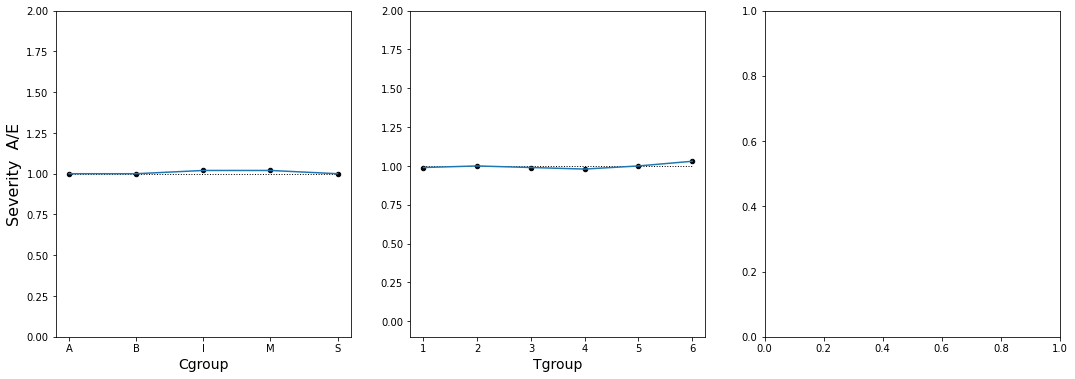

In [81]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

x = x_driver_age
y = np.ones( len(x) )
ax[0].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[0].scatter(x_driver_age, y_driver_age, s=20, color='black')
ax[0].plot(x_driver_age, y_driver_age, linestyle='solid')
ax[0].set_ylim(-0.,2)
ax[0].set_ylabel('Severity  A/E', fontdict={'size':16})
ax[0].set_xlabel('Cgroup', fontdict={'size':14})

x = x_vehicle_age
y = np.ones( len(x) )
ax[1].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[1].scatter(x_vehicle_age, y_vehicle_age, s=20, color='black')
ax[1].plot(x_vehicle_age, y_vehicle_age, linestyle='solid')
ax[1].set_ylim(-0.1,2)
ax[1].set_xlabel('Tgroup', fontdict={'size':14})

# x = x_license_year
# y = np.ones( len(x) )
# ax[2].plot(x,y, color='black',linestyle='dotted', linewidth=1)
# ax[2].scatter(x_license_year, y_license_year, s=20, color='black')
# ax[2].plot(x_license_year, y_license_year, linestyle='solid')
# ax[2].set_ylim(-0.1,2)
# ax[2].set_xlabel('Rateclass', fontdict={'size':14})

plt.show()

Example : Frequency A/E (Data is Grouped by Variables)

In [82]:
def frequency_A_by_E(data, feature):
    
    grp = data.groupby(by=[feature], as_index=True)
    
    res = grp.apply(lambda x : 
                {'A': x.ClaimNum.sum()/x.EarnExpo.sum(),         
                 'E': (x.PredFrequency*x.EarnExpo).sum()/x.EarnExpo.sum(),   
                 'AE':round(x.ClaimNum.sum()/(x.PredFrequency*x.EarnExpo).sum(),2)
                })
    return res


res1 = frequency_A_by_E(tmp, 'cgroup')
res2 = frequency_A_by_E(tmp, 'tgroup')
#res3 = frequency_A_by_E(tmp, 'rateclass')
    
y_cgroup =[res1.values[x]['AE'] for x in range(res1.shape[0])]
x_cgroup =list(res1.index)

y_tgroup =[res2.values[x]['AE'] for x in range(res2.shape[0])]
x_tgroup =list(res2.index)

# y_rateclass =[res3.values[x]['AE'] for x in range(res3.shape[0])]
# x_rateclass =list(res3.index)

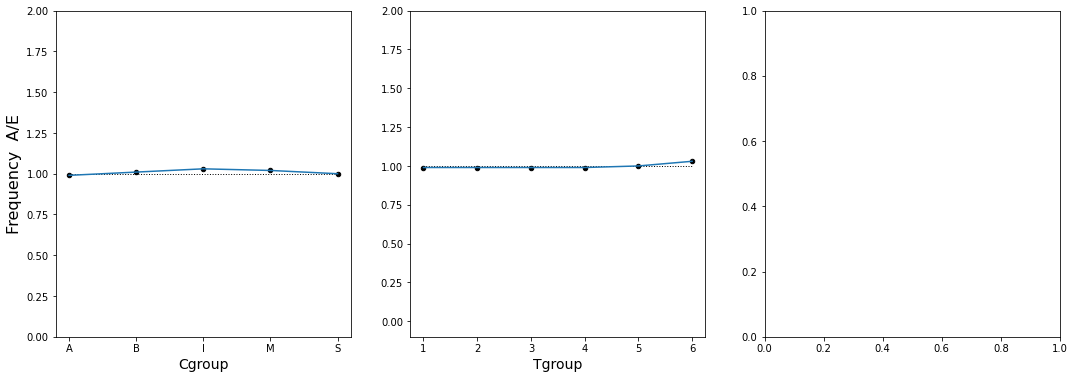

In [83]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

x = x_cgroup
y = np.ones( len(x) )
ax[0].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[0].scatter(x_cgroup, y_cgroup, s=20, color='black')
ax[0].plot(x_cgroup, y_cgroup, linestyle='solid')
ax[0].set_ylim(-0.,2)
ax[0].set_ylabel('Frequency  A/E', fontdict={'size':16})
ax[0].set_xlabel('Cgroup', fontdict={'size':14})

x = x_tgroup
y = np.ones( len(x) )
ax[1].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[1].scatter(x_tgroup, y_tgroup, s=20, color='black')
ax[1].plot(x_tgroup, y_tgroup, linestyle='solid')
ax[1].set_ylim(-0.1,2)
ax[1].set_xlabel('Tgroup', fontdict={'size':14})

# x = x_rateclass
# y = np.ones( len(x) )
# ax[2].plot(x,y, color='black',linestyle='dotted', linewidth=1)
# ax[2].scatter(x_rateclass, y_rateclass, s=20, color='black')
# ax[2].plot(x_rateclass, y_rateclass, linestyle='solid')
# ax[2].set_ylim(-0.1,2)
# ax[2].set_xlabel('Rateclass', fontdict={'size':14})

plt.show()

Example : Pure Premium vs Average Claim Amount

In [84]:
obs_loss = df['TotLoss'].values
exposure = df['EarnExpo'].values
pure_prm = y_pred_f * y_pred_s
exp_loss = y_pred_l

tmp =  pd.DataFrame( 
    np.column_stack((obs_loss, exposure, pure_prm, exp_loss)), 
    columns=['Actual','Exposure','PurePremium','Expected'])

In [85]:
## General Equal-Width Bins
tmp1 = tmp.sort_values(by=['PurePremium'], inplace=False).reset_index(drop=True)

nbins = 10
ppBins = pd.cut( 
    tmp1.PurePremium.to_numpy(), 
    nbins,
    right=True, include_lowest=True, 
    ordered=True)

tmp1['ppGroups'] = ppBins

grp1 = tmp1.groupby(by=['ppGroups'], as_index=False).agg(
    {'Actual':'mean', 
     'Exposure':'sum', 
     'PurePremium':'mean', 
     'Expected': 'mean', 
     'ppGroups': 'count'
    })



## Quantile Equal-Frequency  Bins
tmp2 = tmp.sort_values(by=['PurePremium'], inplace=False).reset_index(drop=True)

nbins = 10
ppBins = pd.qcut( 
    tmp2.PurePremium.to_numpy(), 
    nbins,
    duplicates = 'drop')

tmp2['ppGroups'] = ppBins

grp2 = tmp2.groupby(by=['ppGroups'], as_index=False).agg(
    {'Actual':'mean', 
     'Exposure':'sum', 
     'PurePremium':'mean', 
     'Expected': 'mean',
     'ppGroups': 'count'
    })

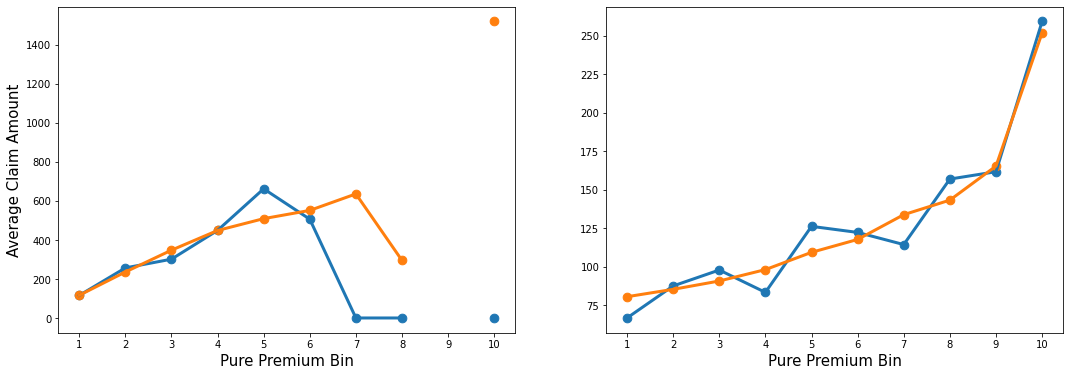

In [86]:
fig, ax = plt.subplots(1,2, figsize=(18,6))

x1 = 1
x2 = grp1.shape[0]+1
ax[0].scatter( np.arange(x1,x2), grp1.Actual.to_list(), color='tab:blue', s=75)
ax[0].plot( np.arange(x1,x2), grp1.Actual.to_numpy(), color='tab:blue', linewidth=3)
ax[0].scatter( np.arange(x1,x2),  grp1.Expected.to_numpy(), color='tab:orange', s=75)
ax[0].plot( np.arange(x1,x2), grp1.Expected.to_numpy(), color='tab:orange', linewidth=3)
ax[0].set_xticks(np.arange(x1,x2))
ax[0].set_xlabel('Pure Premium Bin', fontdict={'size':15})
ax[0].set_ylabel('Average Claim Amount', fontdict={'size':15})
#ax[0].text(1, 315, 'Equal-Width Bins', fontdict={'size':12})


x1 = 1
x2 = grp2.shape[0]+1
ax[1].scatter( np.arange(x1,x2), grp2.Actual.to_list(), color='tab:blue', s=75)
ax[1].plot( np.arange(x1,x2), grp2.Actual.to_numpy(), color='tab:blue', linewidth=3)

ax[1].scatter( np.arange(x1,x2),  grp2.Expected.to_numpy(), color='tab:orange', s=75)
ax[1].plot( np.arange(x1,x2), grp2.Expected.to_numpy(), color='tab:orange', linewidth=3)

ax[1].set_xticks(np.arange(x1,x2))
ax[1].set_xlabel('Pure Premium Bin', fontdict={'size':15})
#ax[1].text(1, 120, 'Equal-Frequency Bins', fontdict={'size':12})

plt.show()

Example : Gini Index

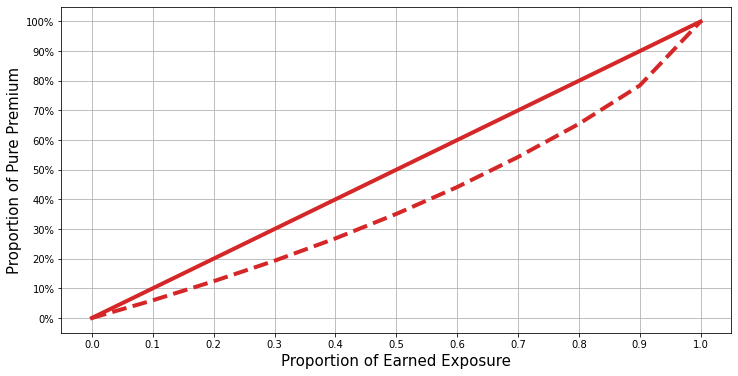

In [87]:
fig, ax = plt.subplots(1,1, figsize=(12,6))

pp_frac = np.cumsum( grp2.PurePremium.to_numpy() )
pp_frac = pp_frac/pp_frac.max()
pp_frac = 100 * np.array( [0] + list(pp_frac) )


x1 = 0
x2 = grp2.shape[0]+1
x = np.arange(x1,x2)
x = x/x.max()
y = 100*x
ax.plot( x, y, color='tab:red', linewidth=4)


ax.plot( x, pp_frac, color='tab:red', linewidth=4, linestyle='dashed')
ax.set_xticks( x )

ax.set_xlabel('Proportion of Earned Exposure', fontdict={'size':15})
ax.set_ylabel('Proportion of Pure Premium', fontdict={'size':15})
ax.set_yticks( np.arange(0,101,10) )
ax.set_yticklabels( [str(x)+'%' for x in np.arange(0,101,10)] )
ax.grid(True)


plt.show()

Calculate Gini Index

In [88]:
def gini_index(xp,yp,delta):
    
    dln = len(xp)
    
    if any(yp > 1.0):
        yp = yp/100.
    else:
        yp = yp

    x  = np.arange(0,1,delta)
    y  = np.interp(x, xp, yp)

    area_b = np.trapz(y, x)
    area_a = 0.5-area_b
    
    gini_index = area_a/(area_a+area_b)
    
    return  gini_index

In [89]:
xp = x
yp = pp_frac
delta = 0.01
gini_index(xp,yp,delta)

0.2360954361840445

-------------------------------------------------------------------------------------------------

## Part 2 : Validation Data

In [90]:
data = pd.read_csv('data_purepremium_valid.csv')
df = data[['ann_miles','cgroup','tgroup','rateclass','TotLoss','ClaimNum','EarnExpo']]

Numerical X

In [91]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

tmp = df[['ann_miles']]

scale = MinMaxScaler()
tmp = scale.fit_transform(tmp.values)

XN = pd.DataFrame(tmp, columns=['ann_miles'])   # X Numerical

Categorical  X

In [92]:
_x1 = relevel(df, 'cgroup', 'A')
_x2 = relevel(df, 'tgroup', 6)
_x3 = relevel(df, 'rateclass', 1)

In [93]:
XC = pd.concat([_x1,_x2], axis=1)               # X categorical 

Get X

In [94]:
_XC_ = pd.get_dummies( XC, drop_first=True )

In [95]:
X = pd.concat([XN,_XC_], axis=1)

Claim Frequency Prediction

In [96]:
y_pred_f = model_frequency.predict(X)
y_pred_f[0:5]

array([0.02945336, 0.03951319, 0.03658721, 0.03230491, 0.03114901])

Summary Statistics of Claim Frequency Prediction

In [97]:
np.quantile( y_pred_f, q=(0.0,0.25,0.50,0.75,1.0) )

array([0.02739262, 0.0366113 , 0.04476484, 0.05611082, 0.66234303])

Claim Severity Prediction

In [98]:
y_pred_s = model_severity.predict(X)
y_pred_s[0:5]

array([3050.7477176 , 2556.94366856, 3063.30916991, 2594.42088226,
       2679.295627  ])

Summary Statistics of Claim Severity Prediction

In [99]:
np.quantile( y_pred_s, q=(0.0,0.25,0.50,0.75,1.0) )

array([2341.02731656, 2854.72042904, 2958.78539937, 3016.05828708,
       3823.73255553])

Actual Loss

In [100]:
loss_actual = df.TotLoss.sum()
print('Actual Loss :', round(loss_actual,4) )

Actual Loss : 6059796


Expected Loss

In [101]:
"""Expected Total Loss using Severity"""
loss_expected_s =  y_pred_s * df.ClaimNum

print('Expected Loss :', round(loss_expected_s.sum(),4) )

Expected Loss : 6352501.9606


In [102]:
pure_premium = y_pred_f * y_pred_s

print('Pure Premium Values   :', [round(x,4) for x in pure_premium[0:5]], '\n')

q = np.quantile( pure_premium, q=(0.0,0.25,0.50,0.75,1.0) )
print('Pure Premium Quartile :', [round(x,4) for x in q] )

Pure Premium Values   : [89.8548, 101.033, 112.078, 83.8125, 83.4574] 

Pure Premium Quartile : [81.7901, 102.8431, 128.5588, 166.0955, 2223.2308]


In [103]:
y_pred_l = pure_premium * df.EarnExpo.values
loss_expected = np.sum( y_pred_l )
print('Expected Loss :', round(loss_expected,4) )

Expected Loss : 6383504.3197


### Model Performance of the Validation Data

Example : A/E for Entire Dataset

In [104]:
A_by_E = loss_actual/loss_expected
A_by_E

0.9492898722236439

Example : Loss A/E (Data is Grouped by Driver Age)

In [105]:
tmp = df.copy()
tmp['PredFrequency'] = y_pred_f
tmp['PredSeverity']  = y_pred_s
tmp['ExpectedLoss']  = y_pred_l

In [106]:
grp1 = tmp.groupby(by=['cgroup'], as_index=True)
res1 = grp1.apply(lambda x : 
                {'A': sum(x.TotLoss), 
                 'E': sum(x.ExpectedLoss),
                 'AE':round(sum(x.TotLoss)/sum(x.ExpectedLoss),2)
                })

grp2 = tmp.groupby(by=['tgroup'], as_index=True)
res2 = grp2.apply(lambda x : 
                {'A': sum(x.TotLoss), 
                 'E': sum(x.ExpectedLoss),
                 'AE':round(sum(x.TotLoss)/sum(x.ExpectedLoss),2)
                })

# grp3 = tmp.groupby(by=['rateclass'], as_index=True)
# res3 = grp3.apply(lambda x : 
#                 {'A': sum(x.TotLoss), 
#                  'E': sum(x.ExpectedLoss),
#                  'AE':round(sum(x.TotLoss)/sum(x.ExpectedLoss),2)
#                 })


y_driver_age =[res1.values[x]['AE'] for x in range(res1.shape[0])]
x_driver_age =list(res1.index)

y_vehicle_age =[res2.values[x]['AE'] for x in range(res2.shape[0])]
x_vehicle_age =list(res2.index)

# y_license_year =[res3.values[x]['AE'] for x in range(res3.shape[0])]
# x_license_year =list(res3.index)

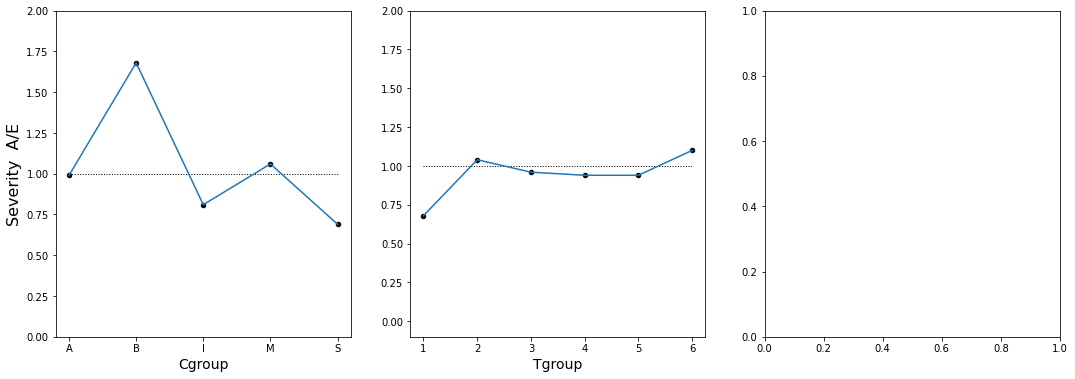

In [107]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

x = x_driver_age
y = np.ones( len(x) )
ax[0].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[0].scatter(x_driver_age, y_driver_age, s=20, color='black')
ax[0].plot(x_driver_age, y_driver_age, linestyle='solid')
ax[0].set_ylim(-0.,2)
ax[0].set_ylabel('Severity  A/E', fontdict={'size':16})
ax[0].set_xlabel('Cgroup', fontdict={'size':14})

x = x_vehicle_age
y = np.ones( len(x) )
ax[1].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[1].scatter(x_vehicle_age, y_vehicle_age, s=20, color='black')
ax[1].plot(x_vehicle_age, y_vehicle_age, linestyle='solid')
ax[1].set_ylim(-0.1,2)
ax[1].set_xlabel('Tgroup', fontdict={'size':14})

# x = x_license_year
# y = np.ones( len(x) )
# ax[2].plot(x,y, color='black',linestyle='dotted', linewidth=1)
# ax[2].scatter(x_license_year, y_license_year, s=20, color='black')
# ax[2].plot(x_license_year, y_license_year, linestyle='solid')
# ax[2].set_ylim(-0.1,2)
# ax[2].set_xlabel('Rateclass', fontdict={'size':14})

plt.show()

Example : Frequency A/E (Data is Grouped by Variables)

In [108]:
def frequency_A_by_E(data, feature):
    
    grp = data.groupby(by=[feature], as_index=True)
    
    res = grp.apply(lambda x : 
                {'A': x.ClaimNum.sum()/x.EarnExpo.sum(),         
                 'E': (x.PredFrequency*x.EarnExpo).sum()/x.EarnExpo.sum(),   
                 'AE':round(x.ClaimNum.sum()/(x.PredFrequency*x.EarnExpo).sum(),2)
                })
    return res


res1 = frequency_A_by_E(tmp, 'cgroup')
res2 = frequency_A_by_E(tmp, 'tgroup')
res3 = frequency_A_by_E(tmp, 'rateclass')
    
y_cgroup =[res1.values[x]['AE'] for x in range(res1.shape[0])]
x_cgroup =list(res1.index)

y_tgroup =[res2.values[x]['AE'] for x in range(res2.shape[0])]
x_tgroup =list(res2.index)

y_rateclass =[res3.values[x]['AE'] for x in range(res3.shape[0])]
x_rateclass =list(res3.index)

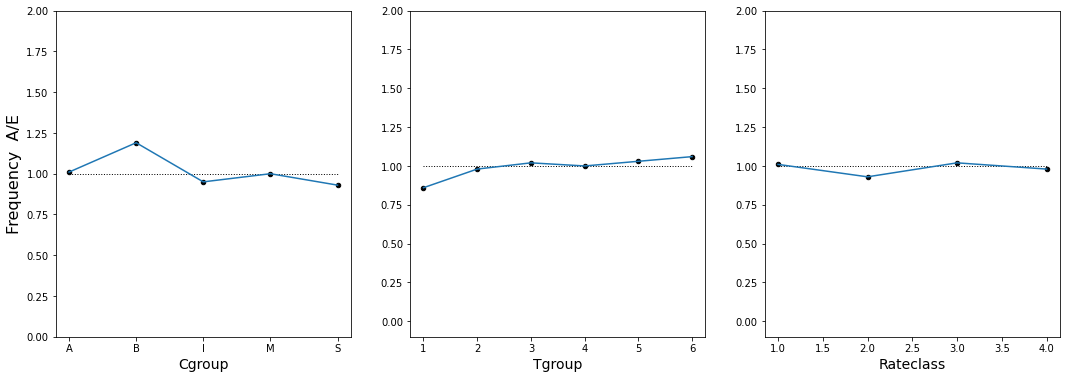

In [109]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

x = x_cgroup
y = np.ones( len(x) )
ax[0].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[0].scatter(x_cgroup, y_cgroup, s=20, color='black')
ax[0].plot(x_cgroup, y_cgroup, linestyle='solid')
ax[0].set_ylim(-0.,2)
ax[0].set_ylabel('Frequency  A/E', fontdict={'size':16})
ax[0].set_xlabel('Cgroup', fontdict={'size':14})

x = x_tgroup
y = np.ones( len(x) )
ax[1].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[1].scatter(x_tgroup, y_tgroup, s=20, color='black')
ax[1].plot(x_tgroup, y_tgroup, linestyle='solid')
ax[1].set_ylim(-0.1,2)
ax[1].set_xlabel('Tgroup', fontdict={'size':14})

x = x_rateclass
y = np.ones( len(x) )
ax[2].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[2].scatter(x_rateclass, y_rateclass, s=20, color='black')
ax[2].plot(x_rateclass, y_rateclass, linestyle='solid')
ax[2].set_ylim(-0.1,2)
ax[2].set_xlabel('Rateclass', fontdict={'size':14})

plt.show()

Example : Pure Premium vs Average Claim Amount

In [110]:
obs_loss = df['TotLoss'].values
exposure = df['EarnExpo'].values
pure_prm = y_pred_f * y_pred_s
exp_loss = y_pred_l

tmp =  pd.DataFrame( 
    np.column_stack((obs_loss, exposure, pure_prm, exp_loss)), 
    columns=['Actual','Exposure','PurePremium','Expected'])

In [111]:
## General Equal-Width Bins
tmp1 = tmp.sort_values(by=['PurePremium'], inplace=False).reset_index(drop=True)

nbins = 10
ppBins = pd.cut( 
    tmp1.PurePremium.to_numpy(), 
    nbins,
    right=True, include_lowest=True, 
    ordered=True)

tmp1['ppGroups'] = ppBins

grp1 = tmp1.groupby(by=['ppGroups'], as_index=False).agg(
    {'Actual':'mean', 
     'Exposure':'sum', 
     'PurePremium':'mean', 
     'Expected': 'mean', 
     'ppGroups': 'count'
    })



## Quantile Equal-Frequency  Bins
tmp2 = tmp.sort_values(by=['PurePremium'], inplace=False).reset_index(drop=True)

nbins = 10
ppBins = pd.qcut( 
    tmp2.PurePremium.to_numpy(), 
    nbins,
    duplicates = 'drop')

tmp2['ppGroups'] = ppBins

grp2 = tmp2.groupby(by=['ppGroups'], as_index=False).agg(
    {'Actual':'mean', 
     'Exposure':'sum', 
     'PurePremium':'mean', 
     'Expected': 'mean',
     'ppGroups': 'count'
    })

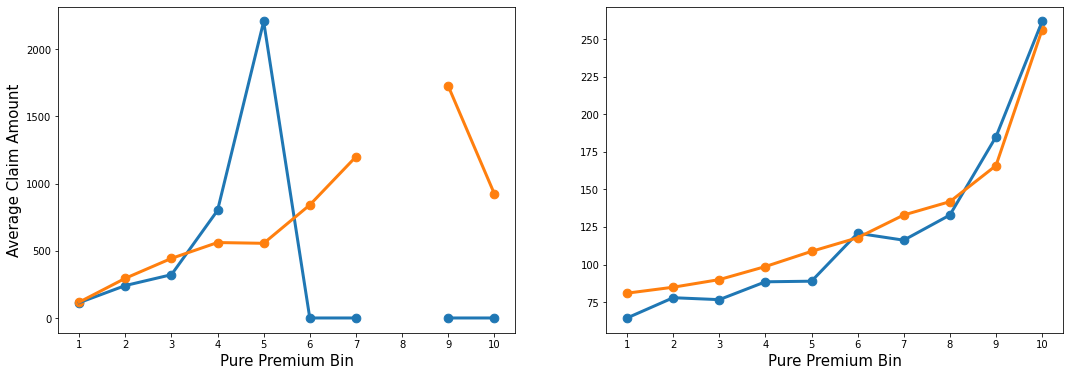

In [112]:
fig, ax = plt.subplots(1,2, figsize=(18,6))

x1 = 1
x2 = grp1.shape[0]+1
ax[0].scatter( np.arange(x1,x2), grp1.Actual.to_list(), color='tab:blue', s=75)
ax[0].plot( np.arange(x1,x2), grp1.Actual.to_numpy(), color='tab:blue', linewidth=3)
ax[0].scatter( np.arange(x1,x2),  grp1.Expected.to_numpy(), color='tab:orange', s=75)
ax[0].plot( np.arange(x1,x2), grp1.Expected.to_numpy(), color='tab:orange', linewidth=3)
ax[0].set_xticks(np.arange(x1,x2))
ax[0].set_xlabel('Pure Premium Bin', fontdict={'size':15})
ax[0].set_ylabel('Average Claim Amount', fontdict={'size':15})
#ax[0].text(1, 315, 'Equal-Width Bins', fontdict={'size':12})


x1 = 1
x2 = grp2.shape[0]+1
ax[1].scatter( np.arange(x1,x2), grp2.Actual.to_list(), color='tab:blue', s=75)
ax[1].plot( np.arange(x1,x2), grp2.Actual.to_numpy(), color='tab:blue', linewidth=3)

ax[1].scatter( np.arange(x1,x2),  grp2.Expected.to_numpy(), color='tab:orange', s=75)
ax[1].plot( np.arange(x1,x2), grp2.Expected.to_numpy(), color='tab:orange', linewidth=3)

ax[1].set_xticks(np.arange(x1,x2))
ax[1].set_xlabel('Pure Premium Bin', fontdict={'size':15})
#ax[1].text(1, 120, 'Equal-Frequency Bins', fontdict={'size':12})

plt.show()

Example : Gini Index

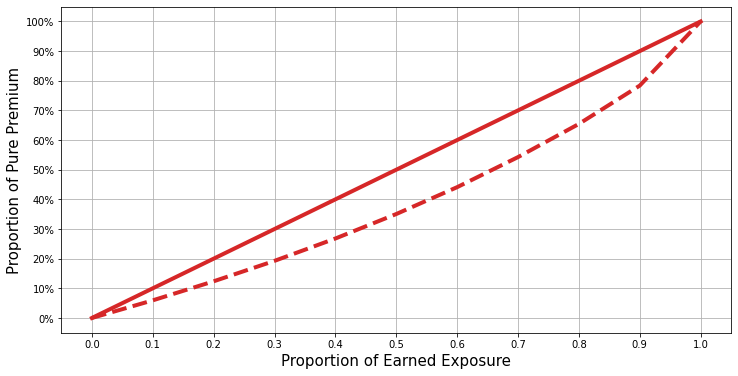

In [113]:
fig, ax = plt.subplots(1,1, figsize=(12,6))

pp_frac = np.cumsum( grp2.PurePremium.to_numpy() )
pp_frac = pp_frac/pp_frac.max()
pp_frac = 100 * np.array( [0] + list(pp_frac) )


x1 = 0
x2 = grp2.shape[0]+1
x = np.arange(x1,x2)
x = x/x.max()
y = 100*x
ax.plot( x, y, color='tab:red', linewidth=4)


ax.plot( x, pp_frac, color='tab:red', linewidth=4, linestyle='dashed')
ax.set_xticks( x )

ax.set_xlabel('Proportion of Earned Exposure', fontdict={'size':15})
ax.set_ylabel('Proportion of Pure Premium', fontdict={'size':15})
ax.set_yticks( np.arange(0,101,10) )
ax.set_yticklabels( [str(x)+'%' for x in np.arange(0,101,10)] )
ax.grid(True)


plt.show()

In [114]:
xp = x
yp = pp_frac
delta = 0.01
gini_index(xp,yp,delta)

0.23659638235178848

## Check  by Hand

In [115]:
from functools import reduce

In [116]:
_bf

,Feature,Estimate,Relativity
0,intercept,-2.83189183,0.05890132
1,ann_miles,1.45303077,4.27605463
2,cgroup_A,0.0,1.0
3,cgroup_B,0.29813267,1.34734053
4,cgroup_I,1.00945298,2.74409953
5,cgroup_M,0.50729838,1.66079828
6,cgroup_S,-0.0109676,0.98909232
7,tgroup_6,0.0,1.0
8,tgroup_1,-0.7552919,0.46987344
9,tgroup_2,-0.62720565,0.53408213


In [117]:
_bs

,Feature,Estimate,Relativity
0,intercept,7.99923723,2978.68506869
1,ann_miles,-0.10497005,0.90035149
2,cgroup_A,0.0,1.0
3,cgroup_B,0.02248188,1.0227365
4,cgroup_I,0.22134636,1.24775553
5,cgroup_M,-0.01371668,0.98637696
6,cgroup_S,0.03035065,1.03081593
7,tgroup_6,0.0,1.0
8,tgroup_1,0.02840085,1.028808
9,tgroup_2,-0.13619976,0.87266829


In [118]:
X = pd.concat([XN,XC], axis=1)
X.head()

,ann_miles,cgroup,tgroup
0,0.042832,A,1
1,0.156897,A,2
2,0.079471,S,3
3,0.018280,A,2
4,0.000752,S,2


In [119]:
y_pred_f[0:3]

array([0.02945336, 0.03951319, 0.03658721])

In [120]:
y_pred_s[0:3]

array([3050.7477176 , 2556.94366856, 3063.30916991])

In [121]:
pure_premium[0:3]

array([ 89.85476142, 101.03299141, 112.0779502 ])

In [122]:
# X = pd.concat([XN,XC], axis=1)
# X = pd.get_dummies(X, drop_first=False)
# x = X.iloc[0, :].values

# bf  = _bf.Estimate.astype(float).values
# bf0 = bf[0]
# bf1 = bf[1:]

# bs  = _bs.Estimate.astype(float).values
# bs0 = bs[0]
# bs1 = bs[1:]

# f = np.exp(bf0) * reduce( lambda x,y : x*y, np.exp(x*bf1))
# s = np.exp(bs0) * reduce( lambda x,y : x*y, np.exp(x*bs1))
# print(f)
# print(s)
# print('pure premium :', f*s)

In [123]:
# bf  = _bf.Relativity.astype(float).values
# bf0 = bf[0]
# bf1 = bf[1:]
# bf1[0] = np.exp( np.log(bf1[0])*0.042832 )

# bs  = _bs.Relativity.astype(float).values
# bs0 = bs[0]
# bs1 = bs[1:]
# bs1[0] = np.exp( np.log(bs1[0])*0.042832 )

In [124]:
# m = [e for e in x*bf1 if e>0]
# f = bf0 * reduce( lambda x,y : x*y, m)
# m = [e for e in x*bs1 if e>0]
# s = bs0 * reduce( lambda x,y : x*y, m)

Row 1

In [125]:
base_frequency         = 0.05890132
ratingclass_relativity = 1.0
territory_relativity   = 0.46987344
milage_coefficient     = np.log(4.27605463)

freq =  base_frequency * ratingclass_relativity * territory_relativity 
freq = freq * np.exp( milage_coefficient *  0.042832 )
freq

0.02945335477986774

In [126]:
base_severity          = 2978.68506869
ratingclass_relativity = 1.0
territory_relativity   = 1.028808
milage_coefficient     = np.log(0.90035149)

severity = base_severity * ratingclass_relativity * territory_relativity 
severity = severity * np.exp( milage_coefficient * 0.042832 )
severity

3050.7477498829603

In [127]:
freq * severity

89.85475582118605

Row 2

In [128]:
base_frequency         = 0.05890132
ratingclass_relativity = 1.0
territory_relativity   = 0.53408213
milage_coefficient     = np.log(4.27605463)

freq =  base_frequency * ratingclass_relativity * territory_relativity 
freq = freq * np.exp( milage_coefficient * 0.156897 )
freq

0.03951316942449296

In [129]:
base_severity          = 2978.68506869
ratingclass_relativity = 1.0
territory_relativity   = 0.87266829
milage_coefficient     = np.log(0.90035149)

severity = base_severity * ratingclass_relativity * territory_relativity 
severity = severity * np.exp( milage_coefficient * 0.156897 )
severity

2556.943767563325

In [130]:
freq * severity

101.03295229663101